In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
block_size = 8
n_embd = 32
head_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
with open('jfk-speeches.txt', encoding="utf-8") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

# Character to integer mapping
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: [itos[i] for i in l]

In [4]:
data = torch.tensor(encode(text), dtype=torch.long)

n = int(len(data) * 0.8)
training_data = data[:n]
validation_data = data[n:]

def get_batch(split):
    training_data if split == 'train' else validation_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # print(ix.shape)
    x = torch.stack([data[i: i + block_size] for i in ix])
    # print(x.shape)
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])

    return x, y

xb, yb = get_batch('train')

In [5]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # attention_scores = queries * keys^T
        attention_scores = torch.matmul(queries, keys.transpose(1, 2))

        # divide since otherwise softmax will explode. Single token will dominate.
        attention_scores = attention_scores / (C ** 0.5)
        attention_scores = attention_scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attention_probs = F.softmax(attention_scores, dim=-1)
        output = attention_probs @ values

        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.project = nn.Linear(num_heads * head_size, n_embd)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        output = torch.cat(head_outputs, dim=-1)
        output = self.project(output)
        output = self.dropout(output)
        return output

class ModelBase(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.transformer = Transformer()
        self.positional_embedding = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.pre_ln = nn.LayerNorm(n_embd) # pre layer norm

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, input, targets=None): # input is B * T (batch size * block size)

        token_embeddings = self.token_embedding(input)
        positional_embeddings = self.positional_embedding(torch.arange(input.shape[1], device=device))
        embeddings = token_embeddings + positional_embeddings
        output = self.transformer(embeddings)
        output = self.pre_ln(output)

        logits = self.lm_head(output)

        if targets is None:
            return logits, None
        else:
            B, T, C = logits.shape

            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

            return logits, loss

        # logits = self.token_embedding(input)

        # B, T, C = logits.shape
        # logits = logits.view(B * T, C)
        # targets = targets.view(B * T)
        # loss = F.cross_entropy(logits, targets)

        # return logits, loss
    
    def generate(self, idx, max_tokens):
        # Get rid of list append - work with tensors instead
        for _ in range(max_tokens):
            # crop idx to block_size tokens if longer
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, _ = self(idx_cond, None)
            # print("logits shape", logits.shape)
            # focus on last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # get probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append to sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layerNorm1 = nn.LayerNorm(n_embd)
        self.layerNorm2 = nn.LayerNorm(n_embd)
        self.attention = MultiHeadAttention(head_size, 8)
        self.feed_forward = FeedForward()

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x + self.dropout(self.attention(self.layerNorm1(x)))
        x = x + self.dropout(self.feed_forward(self.layerNorm2(x)))

        return x

In [6]:
@torch.no_grad()  # disable gradient tracking for efficiency
def estimate_loss():
    out = {}
    m.eval()  # set model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(200)
        for k in range(200):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()  # set model back to training mode
    return out

m = ModelBase(vocab_size)
m = m.to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
logits, loss = m(xb, yb)
# print("loss is", loss.item())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)


In [7]:
train_losses = []
val_losses = []
gradient_norms = []

for i in range(5000):

    if i % 500 == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    # print("loss is", loss.item())
    
    total_norm = 0
    for p in m.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    gradient_norms.append(total_norm)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(m.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if i % 100 == 0:
        print(f"step {i}: loss {loss.item()}")

step 0: train loss 4.3201, val loss 4.3202
step 0: loss 4.3172101974487305
step 100: loss 2.745840549468994
step 200: loss 2.488588333129883
step 300: loss 2.415668249130249
step 400: loss 2.3529398441314697
step 500: train loss 2.3043, val loss 2.3077
step 500: loss 2.4635250568389893
step 600: loss 2.357311487197876
step 700: loss 2.2438149452209473
step 800: loss 2.4741709232330322
step 900: loss 2.1480560302734375
step 1000: train loss 2.2276, val loss 2.2346
step 1000: loss 2.3252902030944824
step 1100: loss 2.045929431915283
step 1200: loss 2.2469918727874756
step 1300: loss 2.3357436656951904
step 1400: loss 2.340178966522217
step 1500: train loss 2.2050, val loss 2.2029
step 1500: loss 2.1447808742523193
step 1600: loss 2.1722912788391113
step 1700: loss 2.2378735542297363
step 1800: loss 2.1871469020843506
step 1900: loss 2.2119174003601074
step 2000: train loss 2.1381, val loss 2.1312
step 2000: loss 2.259982109069824
step 2100: loss 2.0984060764312744
step 2200: loss 2.26504

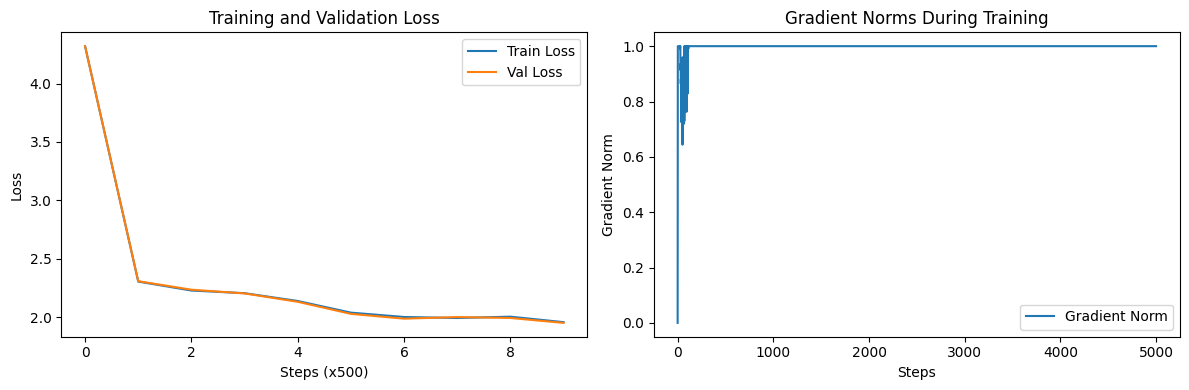

In [8]:
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Steps (x500)')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot gradient norms
plt.subplot(1, 2, 2)
plt.plot(gradient_norms, label='Gradient Norm')
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Initialize context with a single token
context = torch.zeros((1, 1), dtype=torch.long, device=device)
# Generate 100 new tokens
generated_tokens = m.generate(context, max_tokens=500)[0].tolist()
# Convert tokens to text
generated_text = ''.join([itos[i] for i in generated_tokens])
print(generated_text)


Te, pearme thicoorly in purse, frecong the igriomas mormmonts of I this.0t be willogrer. San of Abe husy. And b; to nugh ver nakil the no wave the nepled Tout it woks on poric oneake nust yecan and all Forng elich elea. Thard devers manion equoim Setations Rexaw The redeverefortiacte Armicans. We his effferr yoic Nation thy a beent, jot increpeds ince rof have byetarme sullers.

It whome, what that tot that or pears is ourt not a equire ́lizomstone top at dendiplies nature as sucper the to nesti
